<a href="https://colab.research.google.com/github/iwatsuki-yuuki/college/blob/main/%E6%83%85%E5%A0%B1%E3%82%B7%E3%82%B9%E3%83%86%E3%83%A0%E5%B7%A5%E5%AD%A6%E6%BC%94%E7%BF%92%EF%BC%88%E7%89%B9%E7%95%B0%E5%80%A4%E5%88%86%E8%A7%A3%E8%AA%B2%E9%A1%8C%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 情報システム工学演習I　課題２

In [1]:
# ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from random import gauss
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# データの挿入
# ここではgoogletrendの大阪万博のデータを使用した
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ou_dip/output/multiTimeline (3).csv',header=1)
df['時間'] = pd.to_datetime(df['時間'])
df.set_index('時間',inplace=True)
print(df.columns)
X = df[df.columns[0]].values
df.head()

Index(['大阪万博: (日本)'], dtype='object')


,大阪万博: (日本)
時間,
2025-06-05 15:00:00,42
2025-06-05 16:00:00,36
2025-06-05 17:00:00,36
2025-06-05 18:00:00,35
2025-06-05 19:00:00,39


<Axes: xlabel='時間'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 38442 (\N{CJK UNIFIED IDEOGRAPH-962A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph

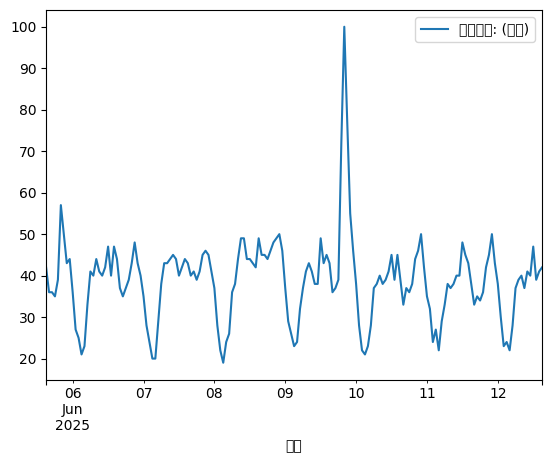

In [14]:
df.plot()

In [15]:
# 特異値分解する
# 部分シーケンス行列 Xw (delay coordinates matrix) を作成する関数
def delay_coordinates(X, w):
  m  = len(X) # m: sequence length len_X = len(X)
  mp = int(np.floor(m / w))
  Xw = np.zeros((mp, w))  # matrix Xw --- size:[mp x w]
  for t in range(1, mp+1):  # t = (1, ..., mp)
    Xw[t-1,:] = X[(t-1)*w:t*w]
  return Xw

def my_svd(Xw, k):
  # 特異値分解 - decompose Xw -> (U, s, Vh)
  [U, s, Vh] = linalg.svd(Xw, full_matrices=False)
  # top-k成分を使った近似 - low-rank approximation
  U_k = U[:,0:k]; s_k = s[0:k]; Vh_k = Vh[0:k,:]
  return (U_k, s_k, Vh_k)


In [16]:
# 時系列データ (1次元)とウィンドウサイズwに対し、k個の重要な特徴的パターンを抽出し、可視化する関数
def svd_decomp(X, w, k, minus=False):
  # (a) 部分シーケンス行列 Xw (delay coordinates matrix) の作成
  Xw = delay_coordinates(X, w) # 部分シーケンス行列を作成
  print(f'create delay coordinates matrix (w={w}),   X: {X.shape} ->  Xw: {Xw.shape}')
  # (b) SVDを用いた行列分解
  (U, s, Vh) = my_svd(Xw, k)
  print(f'top-k decomposed matrices [U * s * Vh] --- size: U:{U.shape}, s:{s.shape}, Vh:{Vh.shape}')
  # (c) 特徴抽出結果の可視化
  if(minus): U*=-1; Vh*=-1 # 必要なら成分の符号を反転させる (可視化のため)
  # ---------------------------- #
  plt.figure(figsize=(6,6))
  colors = ['orange', 'green', 'purple', 'skyblue', 'pink']
  # ---------------------------- #
  plt.subplot(k+1,1,1)
  # (c-i) オリジナルデータとシーケンス分割の可視化
  plt.plot(X)
  for t in range(0,len(Xw)+1):
    plt.axvline(x = t*w, color = 'gray', linestyle='dashed')
  plt.xlabel(f'Time (window size w={w})')
  plt.title(f'Original Sequence X (len={len(X)})')
  # ---------------------------- #
  # (c-ii) 特徴抽出結果 (projection matrix P = U x s)
  for i in range(0,k):
    plt.subplot(k+1,1,i+2)
    plt.stem(U[:,i]*s[i], 'x--', linefmt=colors[i])
    plt.xlabel(f't-th subsequence Xw(t) (t=1,...,{len(Xw)})')
    plt.title(f'Projection matrix P[{i}] = U[{i}]*s[{i}]')
  plt.tight_layout()
  # ---------------------------- #
  # (c-iii) 特徴抽出結果 (Local patterns Vh)
  plt.figure(figsize=(6,2))
  for i in range(0,k):
    plt.subplot(1,k,i+1)
    plt.plot(Vh[i,:], '+-', color=colors[i])
    plt.xlabel(f'Time (window size w={w})')
    plt.title(f'Local patterns Vh[{i}]')
  plt.tight_layout()

create delay coordinates matrix (w=7),   X: (169,) ->  Xw: (24, 7)
top-k decomposed matrices [U * s * Vh] --- size: U:(24, 3), s:(3,), Vh:(3, 7)


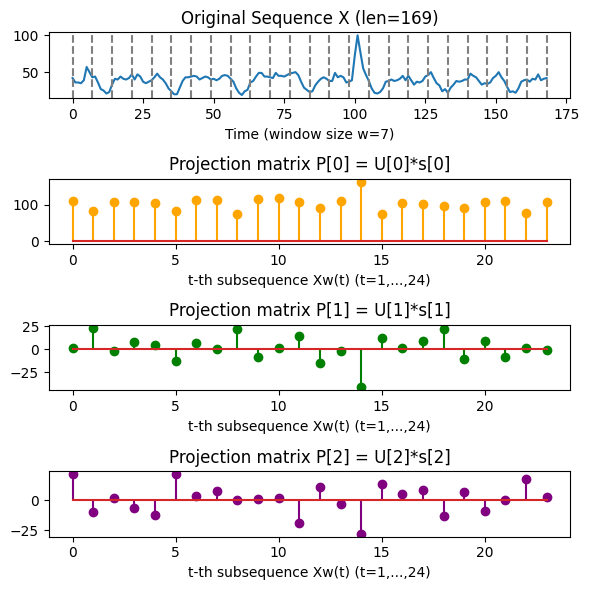

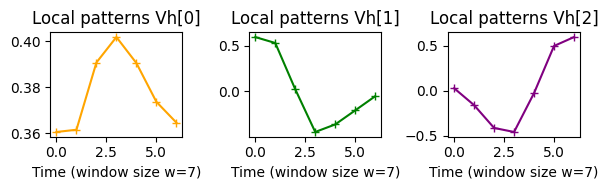

In [25]:
# SVDを用いた特徴抽出
# 1週間のデータなので時間幅を7にした
w = 7 # ウィンドウ幅 50 - window size w
k = 3 # k: 上位 k = 3 個の成分のみ使用
svd_decomp(X, w, k, minus=True)

In [30]:
# top-k成分のみを使ったオリジナルデータの近似 - reconstract Xw using top-k components
def reconstruct(X, w, k):
 # (a) 部分シーケンス行列 Xw (delay coordinates matrix) の作成
  Xw = delay_coordinates(X, w) # 部分シーケンス行列を作成
  print(f'create delay coordinates matrix (w={w}),   X: {X.shape} ->  Xw: {Xw.shape}')
  # (b) SVDを用いた行列分解
  (U, s, Vh) = my_svd(Xw, k)

  # (c) 分解した行列を用いたオリジナルデータの復元と可視化
  plt.figure(figsize=(6,6))
  plt.subplot(k+1, 1, 1)
  plt.plot(X); plt.title(f'Original sequence X')
  for i in range(1,k+1):
    plt.subplot(k+1,1,1+i)
    # i個の成分のみ選択して近似
    U_k = U[:,0:i]; s_k = s[0:i]; Vh_k = Vh[0:i,:]
    Xw_rec  = np.dot(np.dot(U_k, np.diag(s_k)),Vh_k) # delay coordinates matrix
    X_rec   = Xw_rec.flatten() # reconstracted sequence
    plt.plot(X_rec, color='gray')
    plt.title(f'Reconstruction X_rec  (k={i})')
  plt.tight_layout()

create delay coordinates matrix (w=7),   X: (169,) ->  Xw: (24, 7)


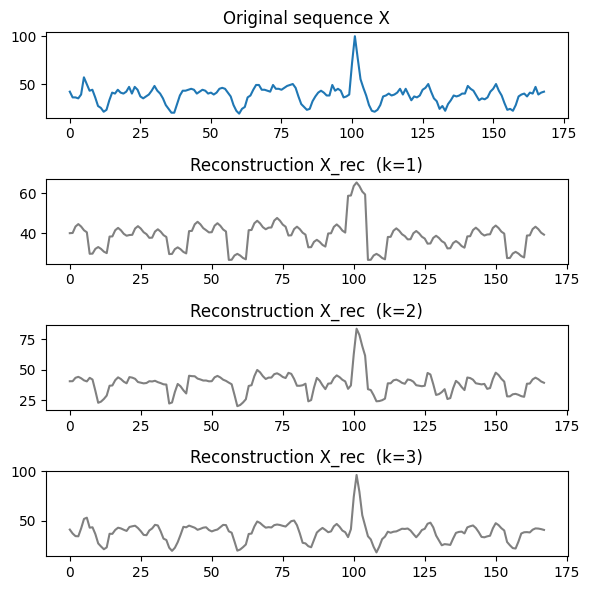

In [31]:
# SVDの行列分解を用いたオリジナルデータの近似を可視化
reconstruct(X,w=7,k=3)

In [ ]:
import numpy as np
import pandas as pd # import pandas

In [ ]:
# キーワード：「olympic」を解析
fn='./data_olympic.csv' # ファイル名を指定
fn='https://www.dm.sanken.osaka-u.ac.jp/~yasuko/EX/data_olympic.csv'
index_col = 'Month' # インデックスを指定
df = pd.read_csv(fn, header=1, index_col=index_col, parse_dates=True)
df.plot(figsize=(8,2)) #可視化 (figure)
X = df['olympic: (Worldwide)'].to_numpy()

#### (3-2) SVDを用いた行列分解

In [ ]:
w = 12 # ウィンドウ幅 12 months - window size w
k = 3  # k: 上位 k = 3 個の成分のみ使用
svd_decomp(X, w, k, minus=True)

#### (3-3) SVDを用いた近似

In [ ]:
# SVDの行列分解を用いたオリジナルデータの近似を可視化
reconstruct(X, w=12,k=4)